In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
I_WIDTH = 320
I_HEIGHT = 240
I_SIZE = I_WIDTH*I_HEIGHT

BLACK = 0
WHITE = 255
SKELETON = 128

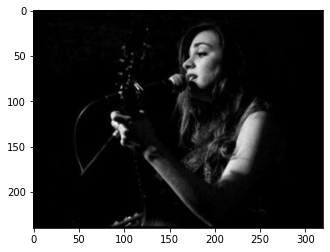

In [66]:
img = cv2.imread('image.jpg',0)
plt.imshow(img, 'gray')

img_one = np.concatenate(img)

rawSkeleton = np.zeros(I_HEIGHT * I_WIDTH)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: overflow encountered in short_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in short_scalars


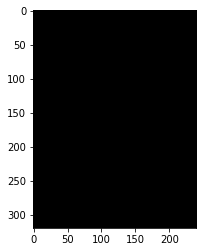

In [94]:
# INFTY=(1+sqrt(static_cast<float>(I_WIDTH*I_WIDTH+I_HEIGHT*I_HEIGHT)));
# int LIM=max(I_HEIGHT,I_WIDTH);
dtline = np.empty((I_WIDTH,I_HEIGHT), dtype=np.int16)
ftline = np.empty(I_WIDTH,  dtype=np.int16)
ftx = np.empty((I_HEIGHT,I_WIDTH),  dtype=np.int16);
dt = np.empty((I_WIDTH,I_HEIGHT),  dtype=np.int16);
ft = np.empty((I_WIDTH,I_WIDTH), dtype=np.int16);
ss = np.empty(I_WIDTH, dtype=np.int16)
tt = np.empty(I_WIDTH+1, dtype=np.int16)

def isBackground(im,x,y):
	return im[y*I_WIDTH+x]==BLACK
 
def euclidnorm(x, y):
  return np.sqrt(x * x + y * y)

def setPixel(im, x, y, value):
	im[y*I_WIDTH+x] = value;

# Classifies a pixel as part of the skeleton or not.
# Input:
# x: first pixel row
# y: first pixel column
# p: second pixel row
# q: second pixel column
# xf: ft value for first pixel
# pf: ft value for second pixel
# yLim: Maximun dimension of the image. (width or height)
# tuneGrain: Type of pruning. Constant, linear or square root
# Output:
# imSal: If the pixel belongs to the skeleton that pixel is assigned SKELETON value.
def compare(x,y, p,q, xf, pf, yLim, tuneGrain, imSal):
  # compute feature transform vectors(xf, yf), (pf, qf)
  # yf, qf, dif;
  yf = xf % yLim ; xf = xf / yLim ;
  qf = pf % yLim ; pf = pf / yLim ;
  dif = (xf - pf) ** 2 + (yf - qf) ** 2
  forth = 1 +((x - xf + p - pf)**2)+((y - yf + q - qf)**2)
  third = forth * tuneGrain * tuneGrain / 4
  second = third if (tuneGrain < 0) else euclidnorm(x-xf+p-pf, y-yf+q-qf) + 2 * ((x-p)*(xf-pf) + (y-q)*(yf-qf)) + 1
  first = tuneGrain * tuneGrain if tuneGrain > 0 else second
  if dif > 1 and dif > first:
  # one of the points is in the skeleton
    innerproduct = (xf-pf)*(xf+pf-x-p) + (yf-qf)*(yf+qf-y-q) ;

  if innerproduct >= 0:
    # setPixel(imSal,x,y,SKELETON)
    imSal[y*I_WIDTH+x] = SKELETON;
  if innerproduct <= 0:
    imSal[q*I_WIDTH+p] = SKELETON;
    # setPixel(imSal,p,q,SKELETON)
  return imgSal
 
def euclideanSkeleton(img_i, outImage):
  # x,y,right,left,xy
  yLim=I_HEIGHT
  xLim=I_WIDTH;
  q=0;
  w=0; 

  # Phase 1
  for y in range(yLim):
    # a if a < b else b 
    right = 0 if isBackground(img_i, xLim - 1,y) else INFTY
    dtline[xLim - 1][y] = right
    # INFTY simulates a isBackground outside the image */

    # (*scan 1*)
    # for n in range(6,0,-1):
    for x in range(xLim - 2, 0, -1):
      right = 0 if isBackground(img_i,x,y) else right + 1
      dtline[x][y] = right

    # (*scan 2*)
    ftx[y][0] = left = dtline[0][y]
    for x in range(xLim):
      right = dtline[x][y]
      left = left if x - left <= right else x + right
      ftx[y][x] = left

  maxDt=0;	
  for x in range(xLim):
    for y in range(yLim):
      ftline[y] = xy = ftx[y][x]
      dtline[x][y] = (xy - x) ** 2

    # (*scan 1*)
    tt[0] = 0
    ss[0] = 0
    q = 0 
    for j in range(yLim):
      leftSide = (j-ss[q])*(j+ss[q]-2*tt[q])
      c = dtline[x]
      d = int(ss[q])
      a = c[d]
      b = dtline[x][j]
      rightSide = a-b
      while q >= 0 and leftSide < rightSide:
        q = q - 1
        leftSide = (j-ss[q])*(j+ss[q]-2*tt[q])
        rightSide = dtline[x][int(ss[q])]-dtline[x][j]

      if q < 0:
        q = 0
        ss[0] = j
      else:
        top1 = j+ss[q]
        top2 = j-ss[q]
        top3 = dtline[x][j]
        top4 = dtline[x][int(ss[q])]
        top = top1*top2+top3-top4
        bottom = 2*(j-ss[q])
        w=top/bottom + 1
        if w < yLim:
          q = q + 1
          ss[q] = j
          tt[q] = w 

    # (*scan 2*)
    for  j in range(yLim - 1, 0, -1):
      dt[x][j] = dtline[x][int(ss[q])] + (ss[q]-j) ** 2
      # //if (ft[x] != 0) 
      # //{
      # ft[x][j] = /*(ftline == None ? ss[q] : */ftline[ss[q]] * (yLim) + ss[q]/*)*/ ;
      ft[x][j] = ftline[int(ss[q])] * (yLim) + ss[q]
      # //}
      if j == tt[q]:
        q = q - 1
    

    # Compute IMA
  tg=5;
  for x in range(xLim):
    for y in range(yLim):
      if x>0 and (isBackground(img_i,x,y) is False or isBackground(img_i,x-1,y) is False):
          outImage = compare(x, y, x-1, y, ft[x][y], ft[x-1][y],xLim, tg,outImage)

      if y>0 and (isBackground(img_i,x,y) is False or isBackground(img_i,x,y-1) is False):
          outImage = compare(x, y, x, y-1, ft[x][y], ft[x][y-1],yLim, tg,outImage)

  return outImage

nasnew = euclideanSkeleton(img_one, rawSkeleton)

output = np.reshape(nasnew, (I_WIDTH, I_HEIGHT))

plt.imshow(output, 'gray')
